# DTLZ2 Benchmark
## Imports

In [1]:
from bofire.benchmarks.multi import DTLZ2
from bofire.benchmarks.benchmark import run
from bofire.utils.multiobjective import compute_hypervolume
from bofire.data_models.strategies.api import QehviStrategy, QparegoStrategy, RandomStrategy, PolytopeSampler
import bofire.strategies.api as strategies
from bofire.data_models.api import Domain, Outputs, Inputs
from bofire.data_models.features.api import ContinuousInput, ContinuousOutput
from bofire.data_models.objectives.api import MinimizeObjective
from functools import partial
import pandas as pd
import os

SMOKE_TEST = os.environ.get("SMOKE_TEST")

/opt/homebrew/Caskroom/miniforge/base/envs/bofire/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Manual setup of the optimization domain

The following cell shows how to manually setup the optimization problem in BoFire for didactic purposes. In the following the implemented benchmark module is then used.

In [2]:
input_features = Inputs(features=[ContinuousInput(key=f"x_{i}", bounds=(0, 1)) for i in range(6)])
# here the minimize objective is used, if you want to maximize you have to use the maximize objective.
output_features = Outputs(features=[ContinuousOutput(key=f"f_{i}", objective=MinimizeObjective(w=1.)) for i in range(2)])
# no constraints are present so we can create the domain
domain = Domain(inputs=input_features, outputs=output_features)

## Random Strategy

In [3]:
def sample(domain):
    datamodel = PolytopeSampler(domain=domain)
    sampler = strategies.map(data_model=datamodel)
    sampled = sampler.ask(10)
    return sampled

def hypervolume(domain: Domain, experiments: pd.DataFrame) -> float:
    return compute_hypervolume(
        domain, experiments, ref_point={"f_0": 1.1, "f_1": 1.1}
    )

random_results = run(
    DTLZ2(dim=6),
    strategy_factory=RandomStrategy,
    n_iterations=50 if not SMOKE_TEST else 1,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.118: 100%|██████████| 50/50 [00:00<00:00, 98.77it/s]


## QEHVI Strategy
### Automatic run

In [4]:
results = run(
    DTLZ2(dim=6),
    strategy_factory=partial(QehviStrategy, ref_point={"f_0": 1.1, "f_1": 1.1}),
    n_iterations=50 if not SMOKE_TEST else 1,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.381: 100%|██████████| 50/50 [02:04<00:00,  2.50s/it]


### Manual setup

#### Using the default Models

In [5]:
# we get the domain from the benchmark module, in real use case we have to build it on our own
# make sure that the objective is set correctly
domain = DTLZ2(dim=6).domain
# we generate training data
experiments = DTLZ2(dim=6).f(domain.inputs.sample(10), return_complete=True)
# we setup the strategy
# providing of a reference point is not mandatory but can help
# the reference point has to be wrt to the assigned objective always worse than the points on the paretofront.
data_model = QehviStrategy(domain=domain, ref_point={"f_0": 1.1, "f_1": 1.1})
recommender = strategies.map(data_model=data_model)
# we tell the strategy our historical data
recommender.tell(experiments=experiments)
# we ask for a new point to evaluate
candidates = recommender.ask(candidate_count=1)
# we show the candidate
display(candidates)
# this candidate has to be then provided to the benchmark function and evaluated and then told back to the optimizer to get the next candidate



,x_0,x_1,x_2,x_3,x_4,x_5,f_0_pred,f_1_pred,f_0_sd,f_1_sd,f_0_des,f_1_des
0,0.400517,0.417488,0.573703,0.319068,0.746549,0.225116,0.772984,0.802233,0.269332,0.295097,-0.772984,-0.802233


#### Setup specific models

In [7]:
from bofire.data_models.surrogates.api import BotorchSurrogates, SingleTaskGPSurrogate
from bofire.data_models.kernels.api import ScaleKernel, RBFKernel

# in this case you would use non default kernels for the different outputs
# it is also possible to build the models for a subset of the complete features
data_model = QehviStrategy(domain=domain, ref_point={"f_0": 1.1, "f_1": 1.1}, 
    surrogate_specs=BotorchSurrogates(surrogates=[
        SingleTaskGPSurrogate(
            inputs=domain.inputs,
            outputs=Outputs(features=[domain.outputs[0]]), 
            kernel=ScaleKernel(base_kernel=RBFKernel(ard=True))),
        SingleTaskGPSurrogate(
            inputs=domain.inputs,
            outputs=Outputs(features=[domain.outputs[1]]),
            kernel=ScaleKernel(base_kernel=RBFKernel(ard=False))),
    ]))
recommender = strategies.map(data_model=data_model)
# we tell the strategy our historical data
recommender.tell(experiments=experiments)
# we ask for a new point to evaluate
candidates = recommender.ask(candidate_count=1)
# we show the candidate
display(candidates)


,x_0,x_1,x_2,x_3,x_4,x_5,f_0_pred,f_1_pred,f_0_sd,f_1_sd,f_0_des,f_1_des
0,0.962721,0.590134,0.6355,0.064779,1.0,0.207502,0.25204,0.958283,0.145824,0.000918,-0.25204,-0.958283


## QPAREGO Strategy

In [9]:
results_qparego = run(
    DTLZ2(dim=6),
    strategy_factory=partial(QparegoStrategy),
    n_iterations=50 if not SMOKE_TEST else 1,
    metric=hypervolume,
    initial_sampler=sample,
    n_runs=1,
    n_procs=1,
)

run 00 with current best 0.360: 100%|██████████| 50/50 [02:58<00:00,  3.57s/it]


## Performance Plot

Text(0, 0.5, 'f_1')

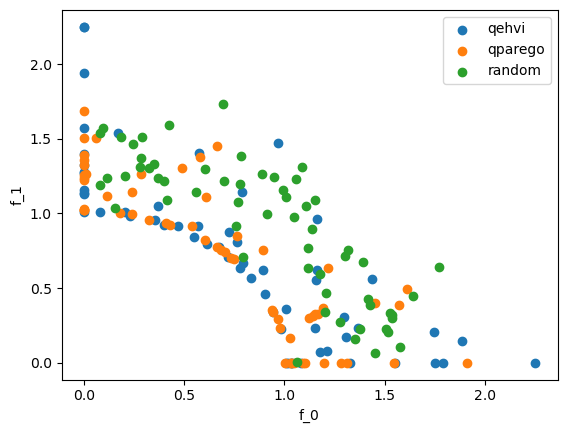

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

ax.scatter(results[0][0].f_0, results[0][0].f_1, label = "qehvi")
ax.scatter(results_qparego[0][0].f_0, results_qparego[0][0].f_1, label = "qparego")
ax.scatter(random_results[0][0].f_0, random_results[0][0].f_1, label = "random")

ax.legend()

ax.set_xlabel("f_0")
ax.set_ylabel("f_1")